# Feature Engineering & Data Preparation

This notebook builds the training and test datasets for FPL points prediction.

**Key design decisions:**
- All rolling features use `shift(1)` to prevent data leakage (GW N only uses data from GW 1..N-1)
- Training: 2022-23 season | Testing: 2023-24 season
- Tier 1 features (~10) for Linear Regression baseline
- Tier 2 features (~29) for XGBoost advanced model
- Double gameweeks aggregated (stats summed per player-round)

In [1]:
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.preprocessing import (
    FPLDataLoader, FPLFeatureEngineer, FPLPreprocessor,
    TIER1_FEATURES, TIER2_FEATURES,
    prepare_training_data, get_feature_columns_by_type
)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', 40)

print('Setup complete')

Setup complete


## 1. Load Raw Data

In [2]:
loader = FPLDataLoader()

# Load training season
train_gw = loader.load_gameweeks('2022-23')
train_teams = loader.load_teams('2022-23')
train_fixtures = loader.load_fixtures('2022-23')

# Load test season
test_gw = loader.load_gameweeks('2023-24')
test_teams = loader.load_teams('2023-24')
test_fixtures = loader.load_fixtures('2023-24')

print(f'Training (2022-23): {len(train_gw):,} records, {train_gw["element"].nunique()} players')
print(f'Testing  (2023-24): {len(test_gw):,} records, {test_gw["element"].nunique()} players')
print(f'\nSample columns: {sorted(train_gw.columns.tolist())[:15]}...')
print(f'Team dtype: {train_gw["team"].dtype}, was_home dtype: {train_gw["was_home"].dtype}')

Training (2022-23): 26,505 records, 778 players
Testing  (2023-24): 29,725 records, 865 players

Sample columns: ['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'element', 'element_type', 'expected_assists', 'expected_goal_involvements', 'expected_goals', 'expected_goals_conceded', 'fixture', 'goals_conceded', 'goals_scored', 'ict_index']...
Team dtype: Int64, was_home dtype: int64


In [3]:
# Quick look at the raw data
print('Target distribution (training):')
print(train_gw['total_points'].describe())
print(f'\nPosition distribution:')
print(train_gw['position_label'].value_counts())

Target distribution (training):
count    26505.000000
mean         1.196906
std          2.355236
min         -4.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         23.000000
Name: total_points, dtype: float64

Position distribution:
position_label
MID    11418
DEF     9183
FWD     3113
GK      2791
Name: count, dtype: int64


## 2. Feature Engineering

**CRITICAL: Data leakage prevention**

All rolling features are computed with `shift(1)`, meaning:
- `form_last_3` at GW 10 = mean of total_points at GW 7, 8, 9 (NOT GW 10)
- This ensures we only use past data when predicting future points

In [4]:
engineer = FPLFeatureEngineer()

print('=== TRAINING DATA ===')
train_feat = engineer.create_all_features(
    train_gw, teams_df=train_teams, fixtures_df=train_fixtures, tier=2
)

print('\n=== TEST DATA ===')
test_feat = engineer.create_all_features(
    test_gw, teams_df=test_teams, fixtures_df=test_fixtures, tier=2
)

=== TRAINING DATA ===
  Creating Tier 1 (baseline) features...
  Creating Tier 2 (extended) features...
  Adding opponent/team features...
  Total engineered features: 49

=== TEST DATA ===
  Creating Tier 1 (baseline) features...
  Creating Tier 2 (extended) features...
  Adding opponent/team features...
  Total engineered features: 49


### 2.1 Verify No Data Leakage

Let's verify with a known player that the shift works correctly.

In [5]:
# Verify with Haaland (high-scoring player)
haaland = train_feat[train_feat['name'].str.contains('Haaland', na=False)].sort_values('round')

verify_cols = ['round', 'total_points', 'form_last_3', 'form_last_5', 
               'goals_last_5', 'minutes_last_3', 'was_home', 'opponent_difficulty']
print('Haaland GW-by-GW (first 10):')
print(haaland[verify_cols].head(10).to_string(index=False))

# Manual verification
gw1_pts = haaland.iloc[0]['total_points']
gw2_pts = haaland.iloc[1]['total_points']
expected_form = (gw1_pts + gw2_pts) / 2
actual_form = haaland.iloc[2]['form_last_3']
print(f'\nVerification: GW1={gw1_pts}, GW2={gw2_pts}')
print(f'  form_last_3 at GW3: expected={expected_form:.1f}, actual={actual_form:.1f}')
print(f'  Match: {np.isclose(expected_form, actual_form)}')

Haaland GW-by-GW (first 10):
 round  total_points  form_last_3  form_last_5  goals_last_5  minutes_last_3  was_home  opponent_difficulty
     1            13          NaN          NaN           NaN             NaN         0                    3
     2             5    13.000000        13.00           2.0       77.000000         1                    2
     3             6     9.000000         9.00           1.0       75.000000         0                    4
     4            17     8.000000         8.00           1.0       80.000000         1                    2
     5            17     9.333333        10.25           1.5       82.000000         1                    2
     6             9    13.333333        11.60           1.8       80.333333         0                    2
     8             6    14.333333        10.80           1.6       80.333333         0                    2
     9            23    10.666667        11.00           1.8       82.666667         1                    3

### 2.2 Examine Feature Distributions

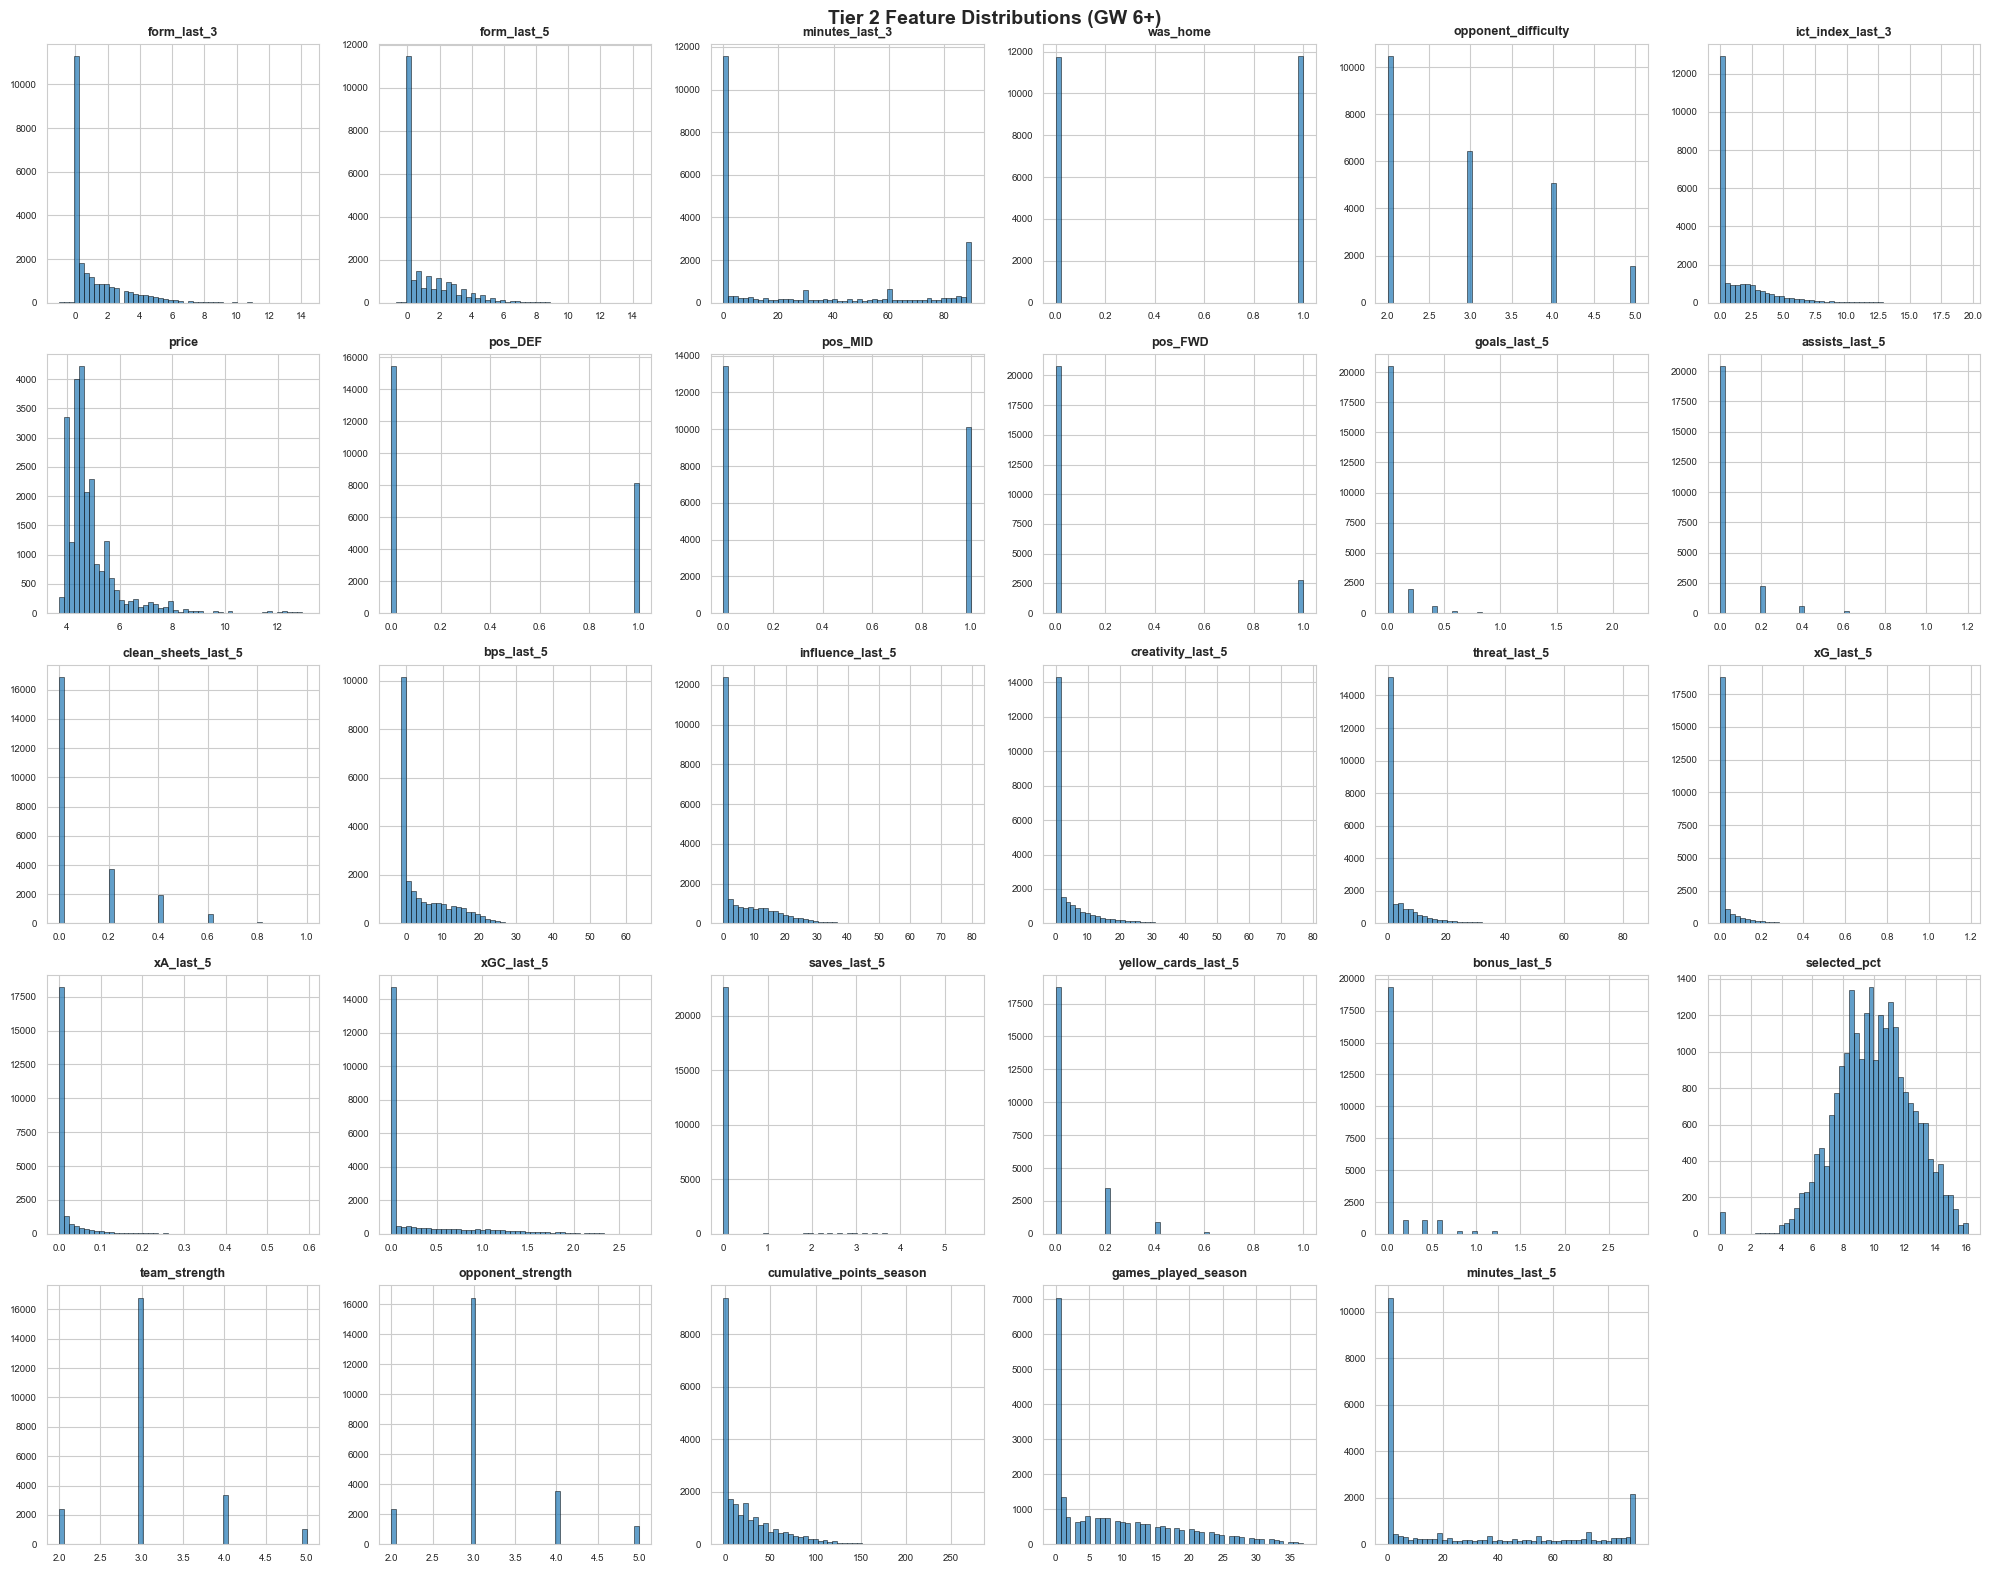

In [6]:
# Feature distributions for Tier 2 features
available_tier2 = [f for f in TIER2_FEATURES if f in train_feat.columns]

# Drop early GWs for cleaner distributions
sample = train_feat[train_feat['round'] >= 6]

fig, axes = plt.subplots(5, 6, figsize=(20, 16))
axes = axes.flatten()

for i, feat in enumerate(available_tier2):
    if i >= len(axes):
        break
    ax = axes[i]
    vals = sample[feat].dropna()
    ax.hist(vals, bins=50, alpha=0.7, edgecolor='black', linewidth=0.5)
    ax.set_title(feat, fontsize=9, fontweight='bold')
    ax.tick_params(labelsize=7)

# Hide empty subplots
for i in range(len(available_tier2), len(axes)):
    axes[i].set_visible(False)

plt.suptitle('Tier 2 Feature Distributions (GW 6+)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 2.3 Feature Correlations with Target

Feature correlations with total_points:
  minutes_last_3                 +0.5127 +++++++++++++++++++++++++
  minutes_last_5                 +0.5053 +++++++++++++++++++++++++
  bps_last_5                     +0.4901 ++++++++++++++++++++++++
  form_last_5                    +0.4896 ++++++++++++++++++++++++
  influence_last_5               +0.4792 +++++++++++++++++++++++
  ict_index_last_3               +0.4766 +++++++++++++++++++++++
  form_last_3                    +0.4695 +++++++++++++++++++++++
  cumulative_points_season       +0.4193 ++++++++++++++++++++
  creativity_last_5              +0.3897 +++++++++++++++++++
  threat_last_5                  +0.3833 +++++++++++++++++++
  selected_pct                   +0.3808 +++++++++++++++++++
  games_played_season            +0.3725 ++++++++++++++++++
  clean_sheets_last_5            +0.3696 ++++++++++++++++++
  xGC_last_5                     +0.3243 ++++++++++++++++
  bonus_last_5                   +0.3165 +++++++++++++++
  price            

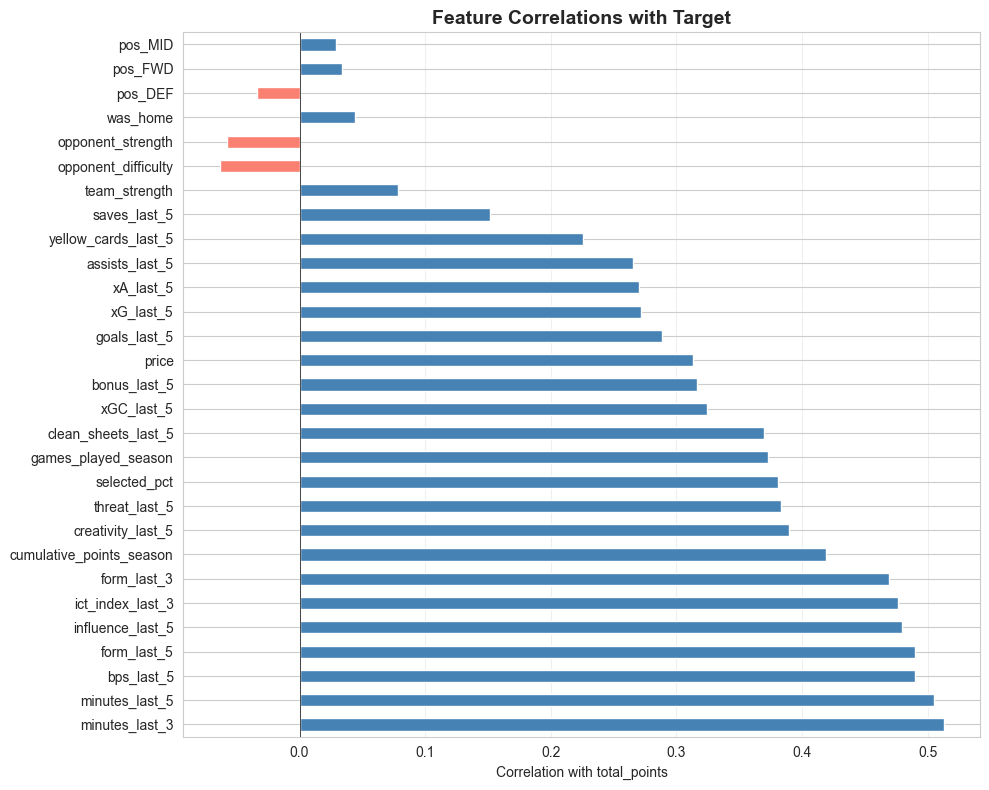

In [7]:
# Correlation of features with total_points
corr_data = train_feat[train_feat['round'] >= 6][available_tier2 + ['total_points']].copy()
correlations = corr_data.corr()['total_points'].drop('total_points').sort_values(key=abs, ascending=False)

print('Feature correlations with total_points:')
print('=' * 50)
for feat, corr in correlations.items():
    bar = '+' * int(abs(corr) * 50)
    print(f'  {feat:30s} {corr:+.4f} {bar}')

# Visualize
plt.figure(figsize=(10, 8))
correlations.plot(kind='barh', color=['steelblue' if x > 0 else 'salmon' for x in correlations])
plt.xlabel('Correlation with total_points')
plt.title('Feature Correlations with Target', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linewidth=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### 2.4 Visualize Rolling Features for a Sample Player

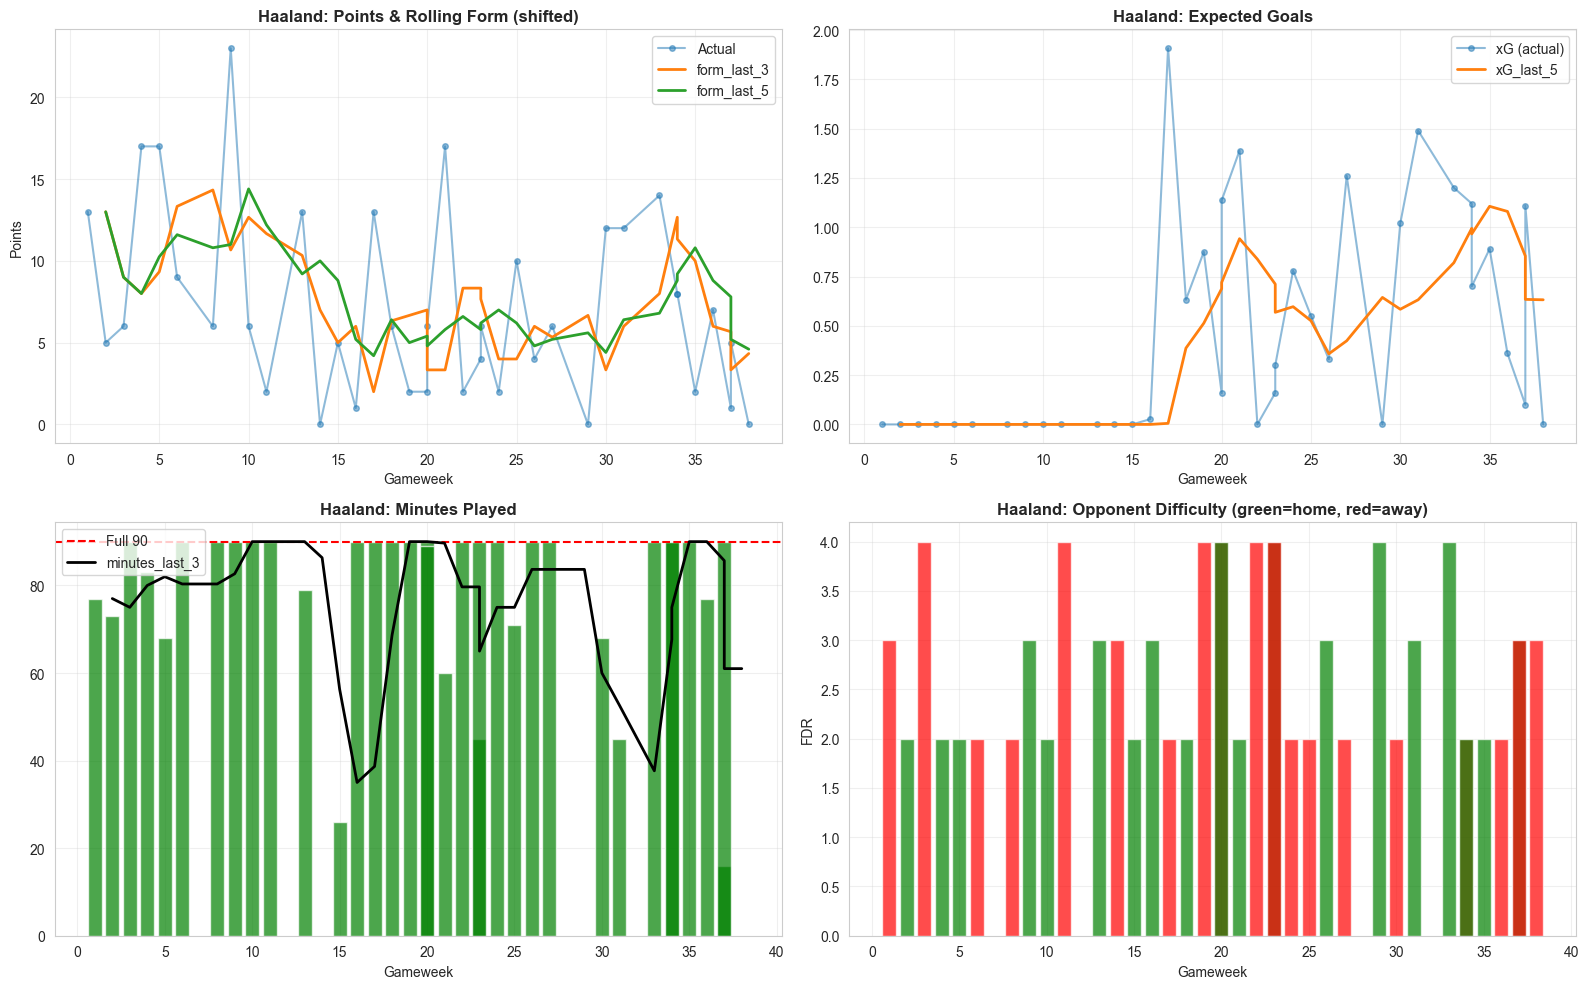

In [8]:
# Pick Haaland for visualization
player_data = train_feat[train_feat['name'].str.contains('Haaland', na=False)].sort_values('round')

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Points vs rolling averages
ax = axes[0, 0]
ax.plot(player_data['round'], player_data['total_points'], 'o-', alpha=0.5, label='Actual', ms=4)
ax.plot(player_data['round'], player_data['form_last_3'], '-', lw=2, label='form_last_3')
ax.plot(player_data['round'], player_data['form_last_5'], '-', lw=2, label='form_last_5')
ax.set_title('Haaland: Points & Rolling Form (shifted)', fontweight='bold')
ax.set_xlabel('Gameweek')
ax.set_ylabel('Points')
ax.legend()
ax.grid(alpha=0.3)

# xG rolling
ax = axes[0, 1]
ax.plot(player_data['round'], player_data['expected_goals'], 'o-', alpha=0.5, label='xG (actual)', ms=4)
ax.plot(player_data['round'], player_data['xG_last_5'], '-', lw=2, label='xG_last_5')
ax.set_title('Haaland: Expected Goals', fontweight='bold')
ax.set_xlabel('Gameweek')
ax.legend()
ax.grid(alpha=0.3)

# Minutes
ax = axes[1, 0]
ax.bar(player_data['round'], player_data['minutes'], alpha=0.7, color='green')
ax.axhline(90, color='red', ls='--', label='Full 90')
ax.plot(player_data['round'], player_data['minutes_last_3'] , 'k-', lw=2, label='minutes_last_3')
ax.set_title('Haaland: Minutes Played', fontweight='bold')
ax.set_xlabel('Gameweek')
ax.legend()
ax.grid(alpha=0.3)

# Opponent difficulty
ax = axes[1, 1]
colors = ['green' if h else 'red' for h in player_data['was_home']]
ax.bar(player_data['round'], player_data['opponent_difficulty'], color=colors, alpha=0.7)
ax.set_title('Haaland: Opponent Difficulty (green=home, red=away)', fontweight='bold')
ax.set_xlabel('Gameweek')
ax.set_ylabel('FDR')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Build Training & Test Datasets

Using the full pipeline: load -> engineer features -> select -> impute -> ready for ML

In [9]:
preprocessor = FPLPreprocessor()

# Build Tier 2 dataset (used for both models - Tier 1 is a subset)
data = preprocessor.build_dataset(
    train_seasons=['2022-23'],
    test_season='2023-24',
    tier=2,
    min_gw=6
)

BUILDING DATASET

1. Loading training data: ['2022-23']
  Loaded 2022-23: 26,505 records, 778 players, 38 GWs

  Found 3096 double-GW records, aggregating...
  After aggregation: 24,957 records

Total: 24,957 player-gameweek records
   Engineering features (Tier 2)...
  Creating Tier 1 (baseline) features...
  Creating Tier 2 (extended) features...
  Adding opponent/team features...
  Total engineered features: 48
   Training records: 22,002

2. Loading test data: 2023-24
  Loaded 2023-24: 29,725 records, 865 players, 38 GWs

  Found 1966 double-GW records, aggregating...
  After aggregation: 28,742 records

Total: 28,742 player-gameweek records
   Engineering features (Tier 2)...
  Creating Tier 1 (baseline) features...
  Creating Tier 2 (extended) features...
  Adding opponent/team features...
  Total engineered features: 48
   Test records: 25,384

3. Features selected (29):
   - form_last_3
   - form_last_5
   - minutes_last_3
   - was_home
   - opponent_difficulty
   - ict_index_l

In [10]:
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

print('Feature list:')
print('=' * 60)
tier1_available = [f for f in TIER1_FEATURES if f in X_train.columns]
tier2_only = [f for f in data['feature_names'] if f not in TIER1_FEATURES]

print(f'\nTier 1 (Linear Regression baseline) - {len(tier1_available)} features:')
for f in tier1_available:
    print(f'  {f}')

print(f'\nTier 2 additions (XGBoost) - {len(tier2_only)} features:')
for f in tier2_only:
    print(f'  {f}')

print(f'\nTotal: {len(data["feature_names"])} features')

Feature list:

Tier 1 (Linear Regression baseline) - 10 features:
  form_last_3
  form_last_5
  minutes_last_3
  was_home
  opponent_difficulty
  ict_index_last_3
  price
  pos_DEF
  pos_MID
  pos_FWD

Tier 2 additions (XGBoost) - 19 features:
  goals_last_5
  assists_last_5
  clean_sheets_last_5
  bps_last_5
  influence_last_5
  creativity_last_5
  threat_last_5
  xG_last_5
  xA_last_5
  xGC_last_5
  saves_last_5
  yellow_cards_last_5
  bonus_last_5
  selected_pct
  team_strength
  opponent_strength
  cumulative_points_season
  games_played_season
  minutes_last_5

Total: 29 features


In [11]:
# Sanity checks
print('SANITY CHECKS')
print('=' * 60)
print(f'NaN in X_train: {X_train.isnull().sum().sum()}')
print(f'NaN in X_test: {X_test.isnull().sum().sum()}')
print(f'NaN in y_train: {y_train.isnull().sum()}')
print(f'NaN in y_test: {y_test.isnull().sum()}')
print(f'\nX_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'\ny_train: mean={y_train.mean():.2f}, std={y_train.std():.2f}, min={y_train.min()}, max={y_train.max()}')
print(f'y_test:  mean={y_test.mean():.2f}, std={y_test.std():.2f}, min={y_test.min()}, max={y_test.max()}')
print(f'\nAll checks passed!' if X_train.isnull().sum().sum() == 0 else 'WARNING: NaN values remain!')

SANITY CHECKS
NaN in X_train: 0
NaN in X_test: 0
NaN in y_train: 0
NaN in y_test: 0

X_train shape: (22002, 29)
X_test shape: (25384, 29)

y_train: mean=1.26, std=2.49, min=-3, max=26
y_test:  mean=1.08, std=2.38, min=-4, max=29

All checks passed!


## 4. Train/Test Distribution Comparison

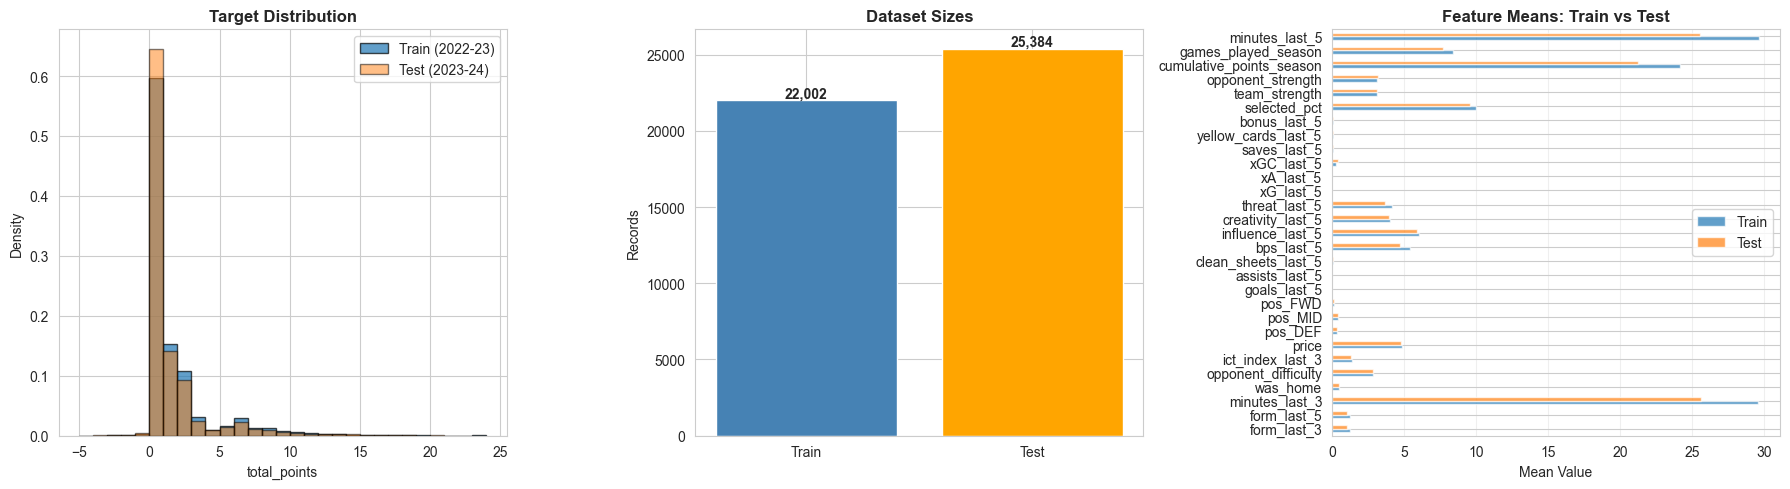

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Target distribution
axes[0].hist(y_train, bins=range(-5, 25), alpha=0.7, label='Train (2022-23)', edgecolor='black', density=True)
axes[0].hist(y_test, bins=range(-5, 25), alpha=0.5, label='Test (2023-24)', edgecolor='black', density=True)
axes[0].set_title('Target Distribution', fontweight='bold')
axes[0].set_xlabel('total_points')
axes[0].set_ylabel('Density')
axes[0].legend()

# Dataset sizes
axes[1].bar(['Train', 'Test'], [len(X_train), len(X_test)], color=['steelblue', 'orange'])
axes[1].set_title('Dataset Sizes', fontweight='bold')
axes[1].set_ylabel('Records')
for i, v in enumerate([len(X_train), len(X_test)]):
    axes[1].text(i, v + 200, f'{v:,}', ha='center', fontweight='bold')

# Feature means comparison
means = pd.DataFrame({
    'Train': X_train.mean(),
    'Test': X_test.mean()
})
means.plot(kind='barh', ax=axes[2], alpha=0.7)
axes[2].set_title('Feature Means: Train vs Test', fontweight='bold')
axes[2].set_xlabel('Mean Value')
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Position-Specific Analysis

In [13]:
# Check target distribution by position
train_full = data['train_df']
test_full = data['test_df']

print('Target stats by position (training):')
print('=' * 60)
for pos in ['GK', 'DEF', 'MID', 'FWD']:
    pos_data = train_full[train_full['position_label'] == pos]['total_points']
    print(f'  {pos:3s}: n={len(pos_data):5,}, mean={pos_data.mean():.2f}, '
          f'std={pos_data.std():.2f}, max={pos_data.max()}')

Target stats by position (training):
  GK : n=2,324, mean=1.04, std=2.39, max=16
  DEF: n=7,592, mean=1.14, std=2.36, max=24
  MID: n=9,467, mean=1.34, std=2.49, max=26
  FWD: n=2,619, mean=1.48, std=2.85, max=24


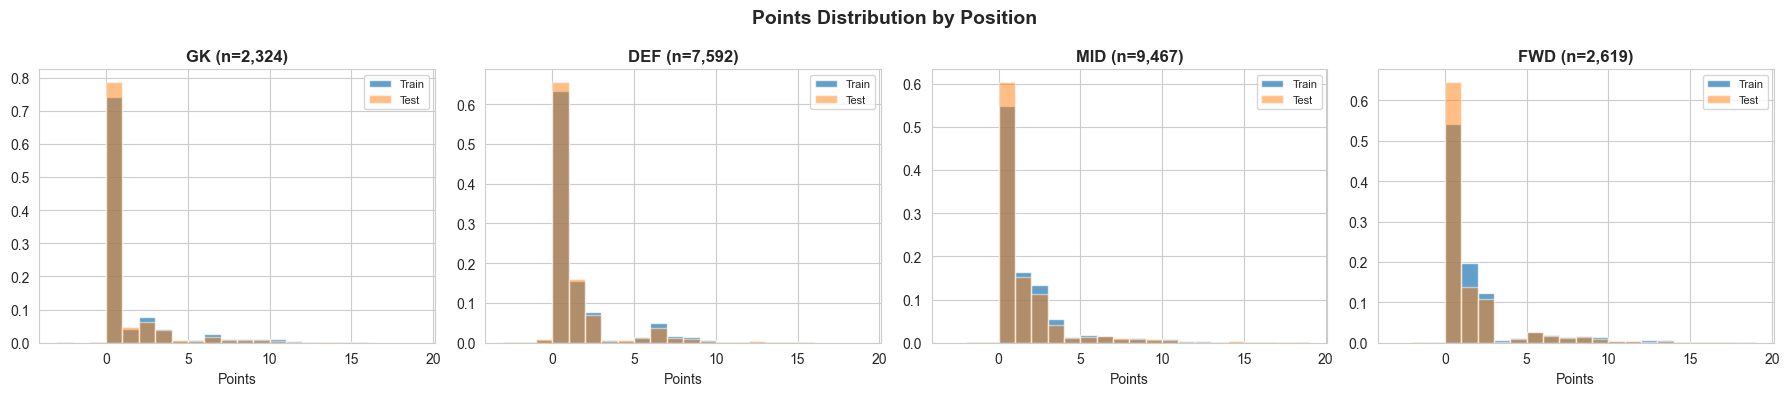

In [14]:
# Position distribution visualization
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

for i, pos in enumerate(['GK', 'DEF', 'MID', 'FWD']):
    pos_train = train_full[train_full['position_label'] == pos]['total_points']
    pos_test = test_full[test_full['position_label'] == pos]['total_points']
    
    axes[i].hist(pos_train, bins=range(-3, 20), alpha=0.7, label='Train', density=True)
    axes[i].hist(pos_test, bins=range(-3, 20), alpha=0.5, label='Test', density=True)
    axes[i].set_title(f'{pos} (n={len(pos_train):,})', fontweight='bold')
    axes[i].set_xlabel('Points')
    axes[i].legend(fontsize=8)

plt.suptitle('Points Distribution by Position', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Save Processed Data

In [15]:
# Save datasets
preprocessor.save(data, name='tier2_2022-23_to_2023-24')

# Also save the full feature-engineered DataFrames for later analysis
from configs.config import PROCESSED_DATA_DIR

output_dir = PROCESSED_DATA_DIR / 'tier2_2022-23_to_2023-24'
train_full.to_csv(output_dir / 'train_full.csv', index=False)
test_full.to_csv(output_dir / 'test_full.csv', index=False)
print(f'\nFull DataFrames saved (for position-specific analysis later)')


Saved to tier2_2022-23_to_2023-24/:
  X_train.csv  ((22002, 29))
  X_test.csv   ((25384, 29))
  y_train.csv  (22002 records)
  y_test.csv   (25384 records)
  pipeline.pkl

Full DataFrames saved (for position-specific analysis later)


## 7. Summary

### What was built:
1. **Data Loader** - handles duplicate columns, team name-to-ID mapping, double GW aggregation
2. **Feature Engineer** - 29 features across 2 tiers, all with `shift(1)` for no data leakage
3. **Preprocessing Pipeline** - imputation, optional scaling, clean train/test split

### Features created:
| Tier | Feature | Description |
|------|---------|-------------|
| 1 | form_last_3, form_last_5 | Avg points in last 3/5 GWs |
| 1 | minutes_last_3 | Avg minutes played |
| 1 | was_home | Home (1) / Away (0) |
| 1 | opponent_difficulty | FDR from fixtures.csv |
| 1 | ict_index_last_3 | ICT index rolling avg |
| 1 | price | Player cost / 10 |
| 1 | pos_DEF/MID/FWD | Position one-hot |
| 2 | goals/assists/cs_last_5 | Rolling stats |
| 2 | xG/xA/xGC_last_5 | Expected stats rolling |
| 2 | team/opponent_strength | From teams.csv |
| 2 | cumulative_points_season | Season running total |

### Data leakage prevention verified:
- `form_last_3` at GW3 = mean(GW1, GW2) points only
- GW1 has NaN for all rolling features (no prior data)
- First 5 GWs dropped from training (incomplete rolling windows)

### Next steps:
- **Notebook 03**: Train Linear Regression (Tier 1 features)
- **Notebook 04**: Train XGBoost (Tier 2 features)
- **Notebook 05**: Compare models, evaluate against paper benchmarks